In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt

from sklearn import metrics
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [2]:
# Prediction of passenger data for Ruter 
# A prediction algorithm which predicts the number of passengers on a specific date for a specific bus 
# Input is date and output is number of passengers. 

# We will train a model using linear regression. First we read in the data.

url = "https://raw.githubusercontent.com/atikagondal/Assignment-2-dave3625-202323/main/Ruter-data.csv"
df = pd.read_csv(url, sep = ';')

df.head()

,TurId,Dato,Fylke,Område,Kommune,Holdeplass_Fra,Holdeplass_Til,Linjetype,Linjefylke,Linjenavn,Linjeretning,Tidspunkt_Faktisk_Ankomst_Holdeplass_Fra,Tidspunkt_Faktisk_Avgang_Holdeplass_Fra,Tidspunkt_Planlagt_Ankomst_Holdeplass_Fra,Tidspunkt_Planlagt_Avgang_Holdeplass_Fra,Kjøretøy_Kapasitet,Passasjerer_Ombord
0,15006-2020-08-10T10:24:00+02:00,10/08/2020,Viken,Vest,Bærum,Nordliveien,Tjernsmyr,Lokal,Viken,150,0,10:53:53,10:53:59,10:53:00,10:53:00,112,5
1,15002-2020-08-15T12:54:00+02:00,15/08/2020,Viken,Vest,Bærum,Nadderud stadion,Bekkestua bussterminal (Plattform C),Lokal,Viken,150,0,13:12:20,13:12:26,13:12:00,13:12:00,112,5
2,15004-2020-08-03T09:54:00+02:00,03/08/2020,Viken,Vest,Bærum,Ringstabekkveien,Skallum,Lokal,Viken,150,0,10:18:56,10:19:21,10:19:00,10:19:00,112,6
3,15003-2020-07-27T13:00:00+02:00,27/07/2020,Viken,Vest,Bærum,Gruvemyra,Gullhaug,Lokal,Viken,150,1,13:52:04,13:52:26,13:51:00,13:51:00,112,10
4,15002-2020-08-27T07:15:00+02:00,27/08/2020,Viken,Vest,Bærum,Lysaker stasjon (Plattform A),Tjernsmyr,Lokal,Viken,150,1,07:34:13,07:34:53,07:33:00,07:33:00,112,10


In [3]:
# We choose the bus 150
df = df.drop('TurId', axis=1)
df = df.drop('Fylke', axis=1)
df = df.drop('Område', axis=1)
df = df.drop('Kommune', axis=1)
df = df.drop('Holdeplass_Fra', axis=1)
df = df.drop('Holdeplass_Til', axis=1)
df = df.drop('Linjetype', axis=1)
df = df.drop('Linjefylke', axis=1)
df = df.drop('Tidspunkt_Faktisk_Ankomst_Holdeplass_Fra', axis=1)
df = df.drop('Tidspunkt_Faktisk_Avgang_Holdeplass_Fra', axis=1)
df = df.drop('Tidspunkt_Planlagt_Ankomst_Holdeplass_Fra', axis=1)
df = df.drop('Tidspunkt_Planlagt_Avgang_Holdeplass_Fra', axis=1)
df = df.drop('Kjøretøy_Kapasitet', axis=1)
df = df.drop('Linjeretning', axis=1)

df = df.query("Linjenavn == '150'")
df = df.drop('Linjenavn', axis=1)
df.head(10)

,Dato,Passasjerer_Ombord
0,10/08/2020,5
1,15/08/2020,5
2,03/08/2020,6
3,27/07/2020,10
4,27/08/2020,10
6,28/07/2020,1
7,27/07/2020,-1
8,16/08/2020,2
9,13/08/2020,4
11,17/08/2020,-2


In [4]:
# Some passenger-numbers are negative. A negative amount of passengers doesn't make sense, so we make them positive.
df['Passasjerer_Ombord'] = df['Passasjerer_Ombord'].abs()

# If we would rather drop the negative values, we would use this following line of code
# df = df.drop(df.index[df['Passasjerer_Ombord'] < 0])

# We convert the date-column to datetime-values and sort the dataframe on the date.
df['Dato']= pd.to_datetime(df['Dato'], format = "%d/%m/%Y")
df = df.sort_values('Dato', ascending=True)
df.head(10)

,Dato,Passasjerer_Ombord
4330,2020-07-09,0
1778,2020-07-11,2
1765,2020-07-12,6
1186,2020-07-12,3
2137,2020-07-16,2
3799,2020-07-16,10
4158,2020-07-17,5
4671,2020-07-17,2
14,2020-07-17,9
3115,2020-07-20,7


In [5]:

df['Dato']= df['Dato'].map(dt.datetime.toordinal)


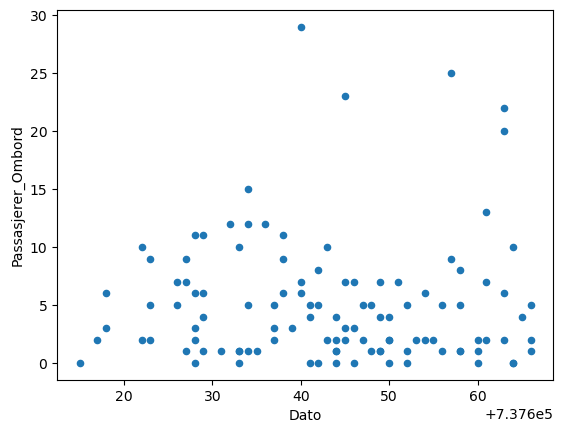

In [6]:
# We can look at the correlation with scatter plots.

df.plot(kind = 'scatter', x = 'Dato', y = 'Passasjerer_Ombord')
plt.show()

<Axes: >

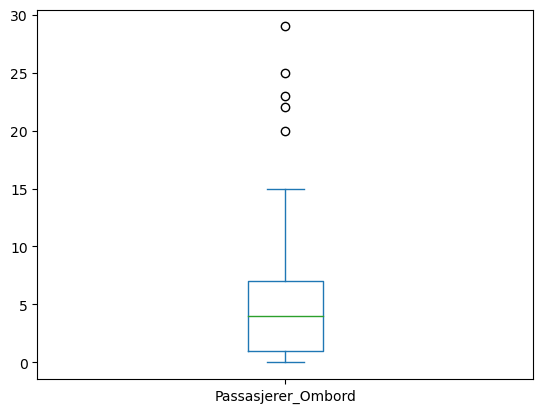

In [7]:
# We can see outliers when doing a boxplot
df['Passasjerer_Ombord'].plot.box()

<Axes: >

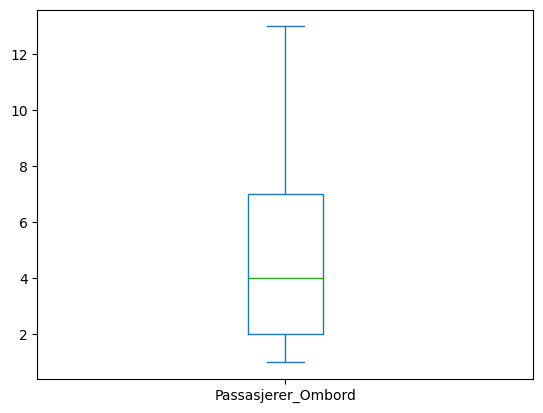

In [8]:
# Remove outliers
from pandas.api.types import is_numeric_dtype

def remove_outlier(df):
    low = .05
    high = .95
    quant_df = df.quantile([low, high])
    if is_numeric_dtype(df):
        df = df[(df > quant_df.loc[low]) & (df < quant_df.loc[high])]
    return df

df['Passasjerer_Ombord'] = remove_outlier(df['Passasjerer_Ombord'])

df['Passasjerer_Ombord'].plot.box()

In [9]:
df=df.dropna()

In [10]:
x = pd.DataFrame(df['Dato']) # Dato
y = pd.DataFrame(df['Passasjerer_Ombord']) # Passasjerer

# Split the set in a training and a testing set

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

In [11]:
# Now 2/3 of the values in Var1 are stored in x_train and 1/3 stored in x_test
# We create a linear regressor model

linear_regressor = LinearRegression()
linear_regressor.fit(x_train, y_train)
y_pred = linear_regressor.predict(x_train) # Make predictions

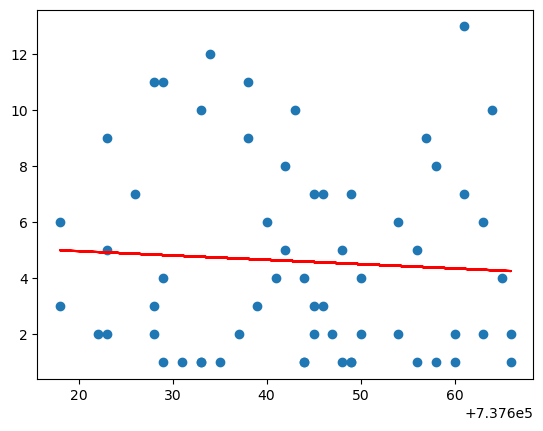

MSE = 11.836273529687386


In [12]:
# Plot the prediction against the result column

plt.scatter(x_train, y_train)
plt.plot(x_train, y_pred, color='red')
plt.show()
print( "MSE = " +str(metrics.mean_squared_error(y_train, y_pred)))
# MSE measures the amount of error in statistical models

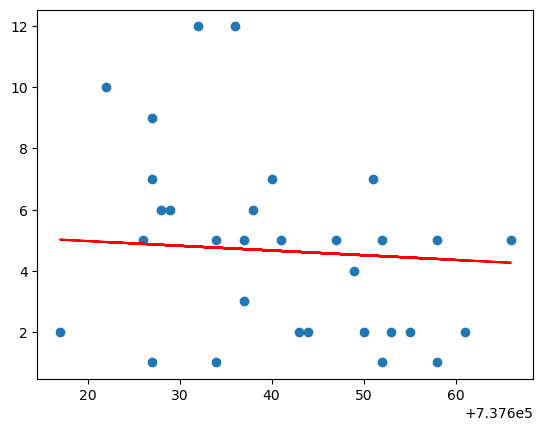

MSE = 8.783990350775248


In [13]:
# Check how good our model works on the test data
y_pred = linear_regressor.predict(x_test)
plt.scatter(x_test, y_test)
plt.plot(x_test, y_pred, color='red')
plt.show()
print( "MSE = "+str(metrics.mean_squared_error(y_test, y_pred)))

In [14]:
r2_score = linear_regressor.score(x_test,y_test)
print(r2_score*100,'%')

4.096628867359531 %
